
Processing with aggregation method: last
AUC Score (last): 0.7096

Processing with aggregation method: mean
AUC Score (mean): 0.7300

Processing with aggregation method: max
AUC Score (max): 0.6673


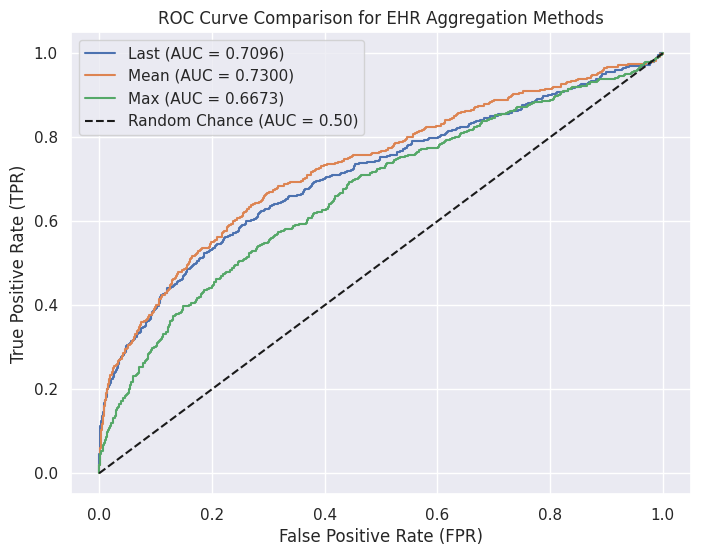

In [ ]:
#auc curve after preprocessing (mean/max/last)
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve # Added roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt # Ensure matplotlib is imported
import os

with open(ehr_pkl_file, 'rb') as f:
    ehr_data = pickle.load(f)
feat_dict = ehr_data['feat_dict']

train_df = pd.read_csv(train_csv_file)
val_df = pd.read_csv(val_csv_file)
train_labels = train_df[['id', 'readmitted_within_30days']].drop_duplicates(subset='id').set_index('id')
val_labels = val_df[['id', 'readmitted_within_30days']].drop_duplicates(subset='id').set_index('id')

def aggregate_features(feat_dict, ids, method='mean'):
    aggregated_data = []
    processed_ids = []
    feature_length = -1
    for admission_id in ids:
        if admission_id in feat_dict:
            daily_features = np.array(feat_dict[admission_id])
            if daily_features.size == 0 or daily_features.shape[0] == 0: continue
            if feature_length == -1:
                if daily_features.ndim > 1: feature_length = daily_features.shape[1]
                else: continue
            if daily_features.ndim < 2 or daily_features.shape[1] != feature_length: continue
            if method == 'last': agg_vector = daily_features[-1, :]
            elif method == 'mean': agg_vector = np.nanmean(daily_features, axis=0)
            elif method == 'max': agg_vector = np.nanmax(daily_features, axis=0)
            else: raise ValueError("Method must be 'last', 'mean', or 'max'")
            aggregated_data.append(agg_vector)
            processed_ids.append(admission_id)
    if not aggregated_data: return np.empty((0, feature_length if feature_length != -1 else 0)), []
    result_matrix = np.vstack(aggregated_data)
    if feature_length != -1 and result_matrix.shape[1] != feature_length: raise ValueError("Inconsistent feature dimensions in final aggregated matrix.")
    return result_matrix, processed_ids

train_ids = train_labels.index.tolist()
val_ids = val_labels.index.tolist()

roc_results = {} 

for method in ['last', 'mean', 'max']:
    print(f"\nProcessing with aggregation method: {method}")

    X_train_agg, processed_train_ids = aggregate_features(feat_dict, train_ids, method=method)
    X_val_agg, processed_val_ids = aggregate_features(feat_dict, val_ids, method=method)

    y_train = train_labels.reindex(processed_train_ids)['readmitted_within_30days']
    y_val = val_labels.reindex(processed_val_ids)['readmitted_within_30days']

    train_nan_mask = y_train.isna(); val_nan_mask = y_val.isna()
    if train_nan_mask.any(): X_train_agg = X_train_agg[~train_nan_mask]; y_train = y_train[~train_nan_mask]
    if val_nan_mask.any(): X_val_agg = X_val_agg[~val_nan_mask]; y_val = y_val[~val_nan_mask]

    y_train = y_train.values; y_val = y_val.values

    # Preprocessing
    imputer = SimpleImputer(strategy='median'); scaler = StandardScaler()
    X_train_imputed = imputer.fit_transform(X_train_agg)
    X_val_imputed = imputer.transform(X_val_agg)
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_val_scaled = scaler.transform(X_val_imputed)

    # Train Model
    model = LogisticRegression(random_state=42, max_iter=1000, C=1.0, solver='liblinear')
    model.fit(X_train_scaled, y_train)

    # Evaluate and Store Results for Plotting
    y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba) # Calculate ROC curve points
    roc_results[method] = {'fpr': fpr, 'tpr': tpr, 'auc': auc_score} # Store results
    print(f"AUC Score ({method}): {auc_score:.4f}")


plt.figure(figsize=(8, 6))

# Plot curve for each method
for method, results in roc_results.items():
    plt.plot(results['fpr'], results['tpr'], label=f"{method.capitalize()} (AUC = {results['auc']:.4f})")

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')

# Add labels and title
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison for EHR Aggregation Methods')
plt.legend()
plt.grid(True)
plt.show()


Processing (Before Scaling) with aggregation method: last
AUC Score (last, Before Scaling): 0.7189

Processing (Before Scaling) with aggregation method: mean
AUC Score (mean, Before Scaling): 0.7347

Processing (Before Scaling) with aggregation method: max
AUC Score (max, Before Scaling): 0.6736


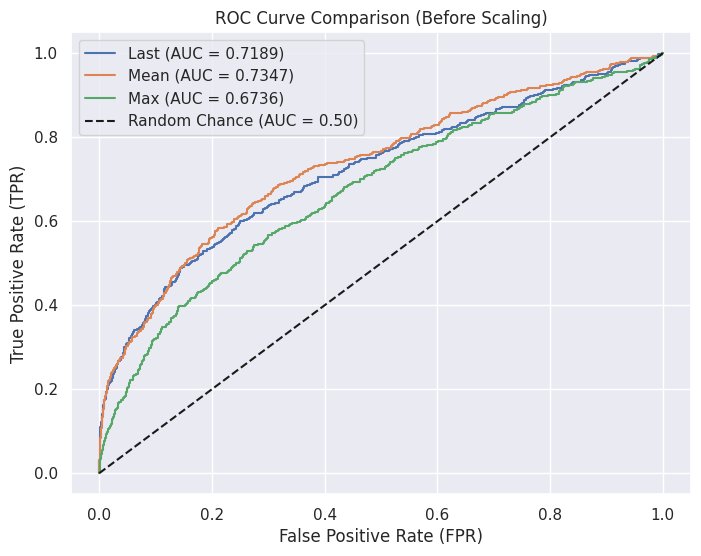

In [ ]:
#auc curve before data preprocessing
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler # Keep import just in case, but won't use scaler
from sklearn.impute import SimpleImputer # Still need imputer for potential NaNs
import matplotlib.pyplot as plt
import os

with open(ehr_pkl_file, 'rb') as f: ehr_data = pickle.load(f)
feat_dict = ehr_data['feat_dict']

train_df = pd.read_csv(train_csv_file); val_df = pd.read_csv(val_csv_file)
train_labels = train_df[['id', 'readmitted_within_30days']].drop_duplicates(subset='id').set_index('id')
val_labels = val_df[['id', 'readmitted_within_30days']].drop_duplicates(subset='id').set_index('id')

def aggregate_features(feat_dict, ids, method='mean'):
    aggregated_data = []
    processed_ids = []
    feature_length = -1
    for admission_id in ids:
        if admission_id in feat_dict:
            daily_features = np.array(feat_dict[admission_id])
            if daily_features.size == 0 or daily_features.shape[0] == 0: continue
            if feature_length == -1:
                if daily_features.ndim > 1: feature_length = daily_features.shape[1]
                else: continue
            if daily_features.ndim < 2 or daily_features.shape[1] != feature_length: continue
            if method == 'last': agg_vector = daily_features[-1, :]
            elif method == 'mean': agg_vector = np.nanmean(daily_features, axis=0)
            elif method == 'max': agg_vector = np.nanmax(daily_features, axis=0)
            aggregated_data.append(agg_vector)
            processed_ids.append(admission_id)
    if not aggregated_data: return np.empty((0, feature_length if feature_length != -1 else 0)), []
    result_matrix = np.vstack(aggregated_data)
    return result_matrix, processed_ids


# --- Prepare Data, Train Models (NO SCALING), and Collect Results ---
train_ids = train_labels.index.tolist()
val_ids = val_labels.index.tolist()
roc_results_unscaled = {} # Store results separately

for method in ['last', 'mean', 'max']:
    print(f"\nProcessing (Before Scaling) with aggregation method: {method}")

    X_train_agg, processed_train_ids = aggregate_features(feat_dict, train_ids, method=method)
    X_val_agg, processed_val_ids = aggregate_features(feat_dict, val_ids, method=method)

    if not processed_train_ids or not processed_val_ids:
         print(f"Skipping method '{method}' - no data aggregated.")
         continue

    y_train = train_labels.reindex(processed_train_ids)['readmitted_within_30days']
    y_val = val_labels.reindex(processed_val_ids)['readmitted_within_30days']
    train_nan_mask = y_train.isna(); val_nan_mask = y_val.isna()
    if train_nan_mask.any(): X_train_agg = X_train_agg[~train_nan_mask]; y_train = y_train[~train_nan_mask]
    if val_nan_mask.any(): X_val_agg = X_val_agg[~val_nan_mask]; y_val = y_val[~val_nan_mask]
    y_train = y_train.values; y_val = y_val.values
    imputer = SimpleImputer(strategy='median')

    # Check for all-NaN columns before imputation which SimpleImputer might not handle well depending on version
    nan_cols_train = np.all(np.isnan(X_train_agg), axis=0)


    X_train_imputed = imputer.fit_transform(X_train_agg)
    X_val_imputed = imputer.transform(X_val_agg)



    model_unscaled = LogisticRegression(random_state=42, max_iter=2000, C=1.0, solver='liblinear') # Increased max_iter
    model_unscaled.fit(X_train_imputed, y_train)

    y_pred_proba_unscaled = model_unscaled.predict_proba(X_val_imputed)[:, 1]
    auc_score_unscaled = roc_auc_score(y_val, y_pred_proba_unscaled)
    fpr_unscaled, tpr_unscaled, _ = roc_curve(y_val, y_pred_proba_unscaled)
    roc_results_unscaled[method] = {'fpr': fpr_unscaled, 'tpr': tpr_unscaled, 'auc': auc_score_unscaled}
    print(f"AUC Score ({method}, Before Scaling): {auc_score_unscaled:.4f}")
  

plt.figure(figsize=(8, 6))

if not roc_results_unscaled:
    print("No results available to plot for the 'Before Scaling' scenario.")
else:
    for method, results in roc_results_unscaled.items():
        plt.plot(results['fpr'], results['tpr'], label=f"{method.capitalize()} (AUC = {results['auc']:.4f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve Comparison (Before Scaling)')
    plt.legend()
    plt.grid(True)
    plt.show()

Generating features aggregated from Last 3 Days using 'mean'...
Training SVM model on Last 3 Days features...
AUC for SVM on Last 3 Days (mean) Features: 0.7460


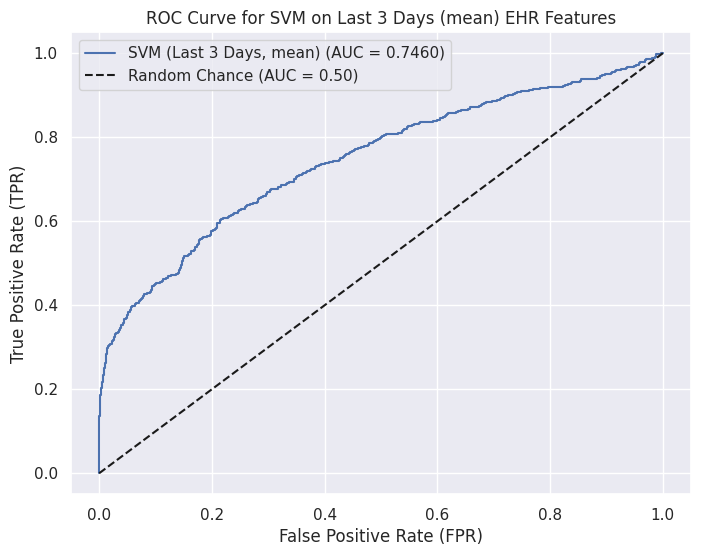

In [ ]:
#AUC for SVM on Last 3 Days (mean)
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve 
import matplotlib.pyplot as plt

def aggregate_features_last_n(feat_dict, ids, n_days=3, method='mean'):

    aggregated_data = []
    processed_ids = []
    feature_length = -1
    for admission_id in ids:
        if admission_id in feat_dict:
            daily_features = np.array(feat_dict[admission_id])
            if daily_features.size == 0 or daily_features.shape[0] == 0: continue
            if feature_length == -1:
                if daily_features.ndim > 1: feature_length = daily_features.shape[1]
                else: continue
            if daily_features.ndim < 2 or daily_features.shape[1] != feature_length: continue
            start_index = max(0, daily_features.shape[0] - n_days)
            relevant_features = daily_features[start_index:, :]
            if relevant_features.shape[0] > 0:
                if method == 'mean': agg_vector = np.nanmean(relevant_features, axis=0)
                elif method == 'max': agg_vector = np.nanmax(relevant_features, axis=0)
                elif method == 'median': agg_vector = np.nanmedian(relevant_features, axis=0)
                else: raise ValueError("Method must be 'mean', 'max', or 'median'")
                aggregated_data.append(agg_vector)
                processed_ids.append(admission_id)
    if not aggregated_data: return np.empty((0, feature_length if feature_length != -1 else 0)), []
    result_matrix = np.vstack(aggregated_data)
    return result_matrix, processed_ids

N_DAYS_TO_AGGREGATE = 3 
AGGREGATION_METHOD = 'mean' # mean/max/last

print(f"Generating features aggregated from Last {N_DAYS_TO_AGGREGATE} Days using '{AGGREGATION_METHOD}'...")

# --- Generate Aggregated Features ---
X_train_agg, processed_train_ids = aggregate_features_last_n(
    feat_dict, train_ids, n_days=N_DAYS_TO_AGGREGATE, method=AGGREGATION_METHOD
)
X_val_agg, processed_val_ids = aggregate_features_last_n(
    feat_dict, val_ids, n_days=N_DAYS_TO_AGGREGATE, method=AGGREGATION_METHOD
)


y_train_aligned = train_labels.reindex(processed_train_ids)['readmitted_within_30days']
y_val_aligned = val_labels.reindex(processed_val_ids)['readmitted_within_30days']

train_nan_mask = y_train_aligned.isna()
val_nan_mask = y_val_aligned.isna()


y_train_aligned = y_train_aligned.values
y_val_aligned = y_val_aligned.values

imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train_agg)
X_val_imputed = imputer.transform(X_val_agg)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

print(f"Training SVM model on Last {N_DAYS_TO_AGGREGATE} Days features...")
svm_model_last_n = SVC(probability=True, random_state=42, C=1.0, kernel='rbf') 
svm_model_last_n.fit(X_train_scaled, y_train_aligned)


y_pred_proba_svm = svm_model_last_n.predict_proba(X_val_scaled)[:, 1]
auc_svm = roc_auc_score(y_val_aligned, y_pred_proba_svm)
print(f"AUC for SVM on Last {N_DAYS_TO_AGGREGATE} Days ({AGGREGATION_METHOD}) Features: {auc_svm:.4f}")

fpr_svm, tpr_svm, _ = roc_curve(y_val_aligned, y_pred_proba_svm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (Last {N_DAYS_TO_AGGREGATE} Days, {AGGREGATION_METHOD}) (AUC = {auc_svm:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve for SVM on Last {N_DAYS_TO_AGGREGATE} Days ({AGGREGATION_METHOD}) EHR Features')
plt.legend()
plt.grid(True)
plt.show()


AUC for SVM on Combined (Mean + Last) Features: 0.7491


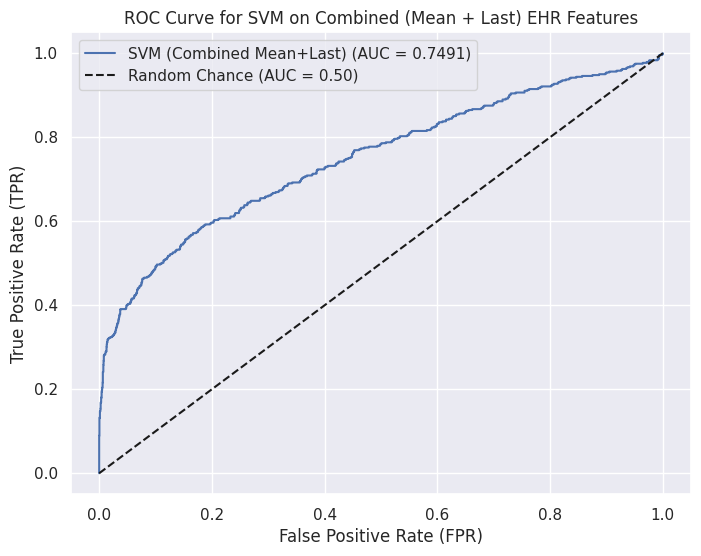

In [ ]:
# AUC for SVM on Combined (Mean + Last) Features
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.metrics import roc_auc_score, roc_curve 
import matplotlib.pyplot as plt 

def aggregate_features(feat_dict, ids, method='mean'):
    aggregated_data = []
    processed_ids = []
    feature_length = -1
    for admission_id in ids:
        if admission_id in feat_dict:
            daily_features = np.array(feat_dict[admission_id])
            if daily_features.size == 0 or daily_features.shape[0] == 0: continue
            if feature_length == -1:
                if daily_features.ndim > 1: feature_length = daily_features.shape[1]
                else: continue
            if daily_features.ndim < 2 or daily_features.shape[1] != feature_length: continue
            if method == 'last': agg_vector = daily_features[-1, :]
            elif method == 'mean': agg_vector = np.nanmean(daily_features, axis=0)
            elif method == 'max': agg_vector = np.nanmax(daily_features, axis=0)
            else: raise ValueError("Method must be 'last', 'mean', or 'max'")
            aggregated_data.append(agg_vector)
            processed_ids.append(admission_id)
    if not aggregated_data: return np.empty((0, feature_length if feature_length != -1 else 0)), []
    result_matrix = np.vstack(aggregated_data)
    if feature_length != -1 and result_matrix.shape[1] != feature_length: raise ValueError("Inconsistent feature dimensions.")
    return result_matrix, processed_ids


X_train_mean, processed_train_ids_mean = aggregate_features(feat_dict, train_ids, method='mean')
X_val_mean, processed_val_ids_mean = aggregate_features(feat_dict, val_ids, method='mean')
X_train_last, processed_train_ids_last = aggregate_features(feat_dict, train_ids, method='last')
X_val_last, processed_val_ids_last = aggregate_features(feat_dict, val_ids, method='last')

common_train_ids = sorted(list(set(processed_train_ids_mean) & set(processed_train_ids_last)))
common_val_ids = sorted(list(set(processed_val_ids_mean) & set(processed_val_ids_last)))

train_mean_map = {id_: i for i, id_ in enumerate(processed_train_ids_mean)}
train_last_map = {id_: i for i, id_ in enumerate(processed_train_ids_last)}
val_mean_map = {id_: i for i, id_ in enumerate(processed_val_ids_mean)}
val_last_map = {id_: i for i, id_ in enumerate(processed_val_ids_last)}

X_train_mean_aligned = X_train_mean[[train_mean_map[id_] for id_ in common_train_ids]]
X_train_last_aligned = X_train_last[[train_last_map[id_] for id_ in common_train_ids]]
X_val_mean_aligned = X_val_mean[[val_mean_map[id_] for id_ in common_val_ids]]
X_val_last_aligned = X_val_last[[val_last_map[id_] for id_ in common_val_ids]]

y_train_aligned = train_labels.reindex(common_train_ids)['readmitted_within_30days'].values
y_val_aligned = val_labels.reindex(common_val_ids)['readmitted_within_30days'].values

X_train_combined = np.concatenate((X_train_mean_aligned, X_train_last_aligned), axis=1)
X_val_combined = np.concatenate((X_val_mean_aligned, X_val_last_aligned), axis=1)

imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train_combined)
X_val_imputed = imputer.transform(X_val_combined)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

svm_model_combined = SVC(probability=True, random_state=42, C=1.0, kernel='rbf') # Example parameters
svm_model_combined.fit(X_train_scaled, y_train_aligned)

y_pred_proba_svm = svm_model_combined.predict_proba(X_val_scaled)[:, 1]
auc_svm = roc_auc_score(y_val_aligned, y_pred_proba_svm)
print(f"AUC for SVM on Combined (Mean + Last) Features: {auc_svm:.4f}")

fpr_svm, tpr_svm, _ = roc_curve(y_val_aligned, y_pred_proba_svm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (Combined Mean+Last) (AUC = {auc_svm:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for SVM on Combined (Mean + Last) EHR Features')
plt.legend()
plt.grid(True)
plt.show()



AUC for SVM on Difference Features: 0.7121


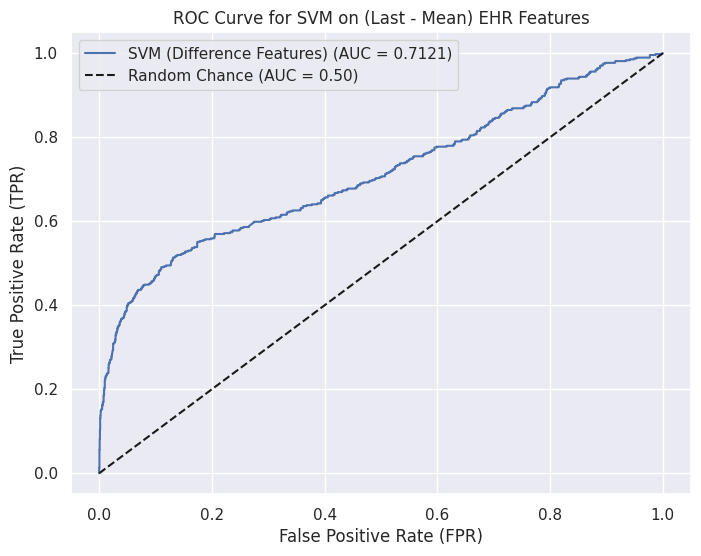

In [ ]:
#AUC for SVM on Combined (Mean + Last) Features
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC # Import SVM Classifier
from sklearn.metrics import roc_auc_score, roc_curve # For evaluation
import matplotlib.pyplot as plt # For plotting ROC

X_train_mean, processed_train_ids_mean = aggregate_features(feat_dict, train_ids, method='mean')
X_val_mean, processed_val_ids_mean = aggregate_features(feat_dict, val_ids, method='mean')

X_train_last, processed_train_ids_last = aggregate_features(feat_dict, train_ids, method='last')
X_val_last, processed_val_ids_last = aggregate_features(feat_dict, val_ids, method='last')

common_train_ids = sorted(list(set(processed_train_ids_mean) & set(processed_train_ids_last)))
common_val_ids = sorted(list(set(processed_val_ids_mean) & set(processed_val_ids_last)))

train_mean_map = {id_: i for i, id_ in enumerate(processed_train_ids_mean)}
train_last_map = {id_: i for i, id_ in enumerate(processed_train_ids_last)}
val_mean_map = {id_: i for i, id_ in enumerate(processed_val_ids_mean)}
val_last_map = {id_: i for i, id_ in enumerate(processed_val_ids_last)}

X_train_mean_aligned = X_train_mean[[train_mean_map[id_] for id_ in common_train_ids]]
X_train_last_aligned = X_train_last[[train_last_map[id_] for id_ in common_train_ids]]
X_val_mean_aligned = X_val_mean[[val_mean_map[id_] for id_ in common_val_ids]]
X_val_last_aligned = X_val_last[[val_last_map[id_] for id_ in common_val_ids]]

y_train_aligned = train_labels.reindex(common_train_ids)['readmitted_within_30days'].values
y_val_aligned = val_labels.reindex(common_val_ids)['readmitted_within_30days'].values

imputer_mean = SimpleImputer(strategy='median')
imputer_last = SimpleImputer(strategy='median') # Use separate imputers if needed, or one fitted on combined

X_train_mean_imputed = imputer_mean.fit_transform(X_train_mean_aligned)
X_val_mean_imputed = imputer_mean.transform(X_val_mean_aligned)

X_train_last_imputed = imputer_last.fit_transform(X_train_last_aligned)
X_val_last_imputed = imputer_last.transform(X_val_last_aligned)

X_train_diff = X_train_last_imputed - X_train_mean_imputed
X_val_diff = X_val_last_imputed - X_val_mean_imputed

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_diff)
X_val_scaled = scaler.transform(X_val_diff)

svm_model = SVC(probability=True, random_state=42, C=1.0, kernel='rbf') #  parameters

svm_model.fit(X_train_scaled, y_train_aligned)

y_pred_proba_svm = svm_model.predict_proba(X_val_scaled)[:, 1]

auc_svm = roc_auc_score(y_val_aligned, y_pred_proba_svm)
print(f"AUC for SVM on Difference Features: {auc_svm:.4f}")

fpr_svm, tpr_svm, _ = roc_curve(y_val_aligned, y_pred_proba_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (Difference Features) (AUC = {auc_svm:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for SVM on (Last - Mean) EHR Features')
plt.legend()
plt.grid(True)
plt.show()

Generating Mean and Last features for combination...
Aligning IDs...
Combining (Mean + Last) features...
Imputing and Scaling combined features...
Prepared Training Data Shape: (8234, 342)
Prepared Validation Data Shape: (2788, 342)
Setting up RandomizedSearchCV...
Starting RandomizedSearchCV (trying 15 combinations)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END C=0.4692680899768591, gamma=0.07969454818643935, kernel=linear; total time= 1.1min
[CV] END C=0.16959629191460518, gamma=0.0013066739238053278, kernel=rbf; total time=  43.2s
[CV] END C=0.16959629191460518, gamma=0.0013066739238053278, kernel=rbf; total time=  43.4s
[CV] END C=0.020799307999138622, gamma=0.08706020878304858, kernel=rbf; total time= 1.5min
[CV] END C=2.789575528819812, gamma=0.0010035927878780913, kernel=rbf; total time=  48.4s
[CV] END C=0.20261142283225705, gamma=0.0040596116104843075, kernel=rbf; total time=  53.6s
[CV] END C=0.9463708738997987, gamma=0.0019010245319870357, kernel=r

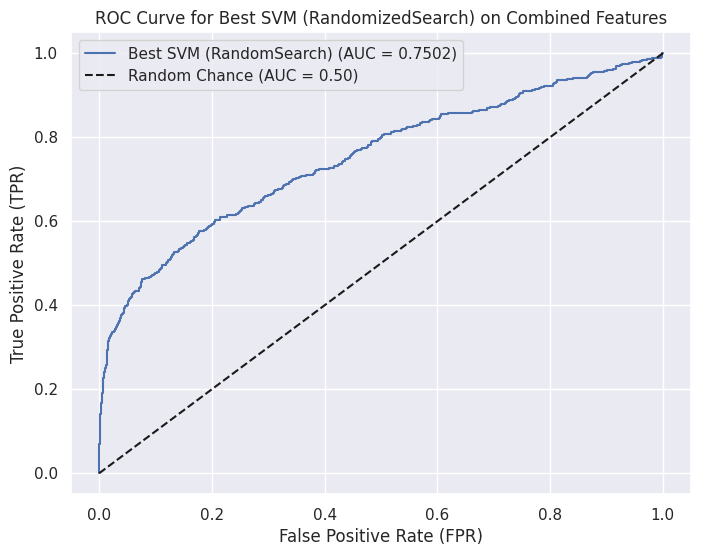

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from scipy.stats import expon, reciprocal 
import matplotlib.pyplot as plt
import time 

def aggregate_features(feat_dict, ids, method='mean'):
    """Aggregates time-series features using the specified method."""
    aggregated_data = []
    processed_ids = []
    feature_length = -1
    for admission_id in ids:
        if admission_id in feat_dict:
            daily_features = np.array(feat_dict[admission_id])
            if daily_features.size == 0 or daily_features.shape[0] == 0: continue
            if feature_length == -1:
                if daily_features.ndim > 1: feature_length = daily_features.shape[1]
                else: continue # Skip if feature array is not 2D
            if daily_features.ndim < 2 or daily_features.shape[1] != feature_length: continue # Skip inconsistent features
            if method == 'last': agg_vector = daily_features[-1, :]
            elif method == 'mean': agg_vector = np.nanmean(daily_features, axis=0)
            elif method == 'max': agg_vector = np.nanmax(daily_features, axis=0)
            else: raise ValueError("Method must be 'last', 'mean', or 'max'")
            aggregated_data.append(agg_vector)
            processed_ids.append(admission_id)
    if not aggregated_data: return np.empty((0, feature_length if feature_length != -1 else 0)), []
    result_matrix = np.vstack(aggregated_data)
    if feature_length != -1 and result_matrix.shape[1] != feature_length: raise ValueError("Inconsistent feature dimensions.")
    return result_matrix, processed_ids



print("Generating Mean and Last features for combination...")
X_train_mean, processed_train_ids_mean = aggregate_features(feat_dict, train_ids, method='mean')
X_val_mean, processed_val_ids_mean = aggregate_features(feat_dict, val_ids, method='mean')
X_train_last, processed_train_ids_last = aggregate_features(feat_dict, train_ids, method='last')
X_val_last, processed_val_ids_last = aggregate_features(feat_dict, val_ids, method='last')

print("Aligning IDs...")
common_train_ids = sorted(list(set(processed_train_ids_mean) & set(processed_train_ids_last)))
common_val_ids = sorted(list(set(processed_val_ids_mean) & set(processed_val_ids_last)))

train_mean_map = {id_: i for i, id_ in enumerate(processed_train_ids_mean)}
train_last_map = {id_: i for i, id_ in enumerate(processed_train_ids_last)}
val_mean_map = {id_: i for i, id_ in enumerate(processed_val_ids_mean)}
val_last_map = {id_: i for i, id_ in enumerate(processed_val_ids_last)}

X_train_mean_aligned = X_train_mean[[train_mean_map[id_] for id_ in common_train_ids]]
X_train_last_aligned = X_train_last[[train_last_map[id_] for id_ in common_train_ids]]
X_val_mean_aligned = X_val_mean[[val_mean_map[id_] for id_ in common_val_ids]]
X_val_last_aligned = X_val_last[[val_last_map[id_] for id_ in common_val_ids]]

y_train_aligned = train_labels.reindex(common_train_ids)['readmitted_within_30days'].values
y_val_aligned = val_labels.reindex(common_val_ids)['readmitted_within_30days'].values

print("Combining (Mean + Last) features...")
X_train_combined = np.concatenate((X_train_mean_aligned, X_train_last_aligned), axis=1)
X_val_combined = np.concatenate((X_val_mean_aligned, X_val_last_aligned), axis=1)

print("Imputing and Scaling combined features...")
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train_combined)
X_val_imputed = imputer.transform(X_val_combined)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_combined) 

print(f"Prepared Training Data Shape: {X_train_scaled.shape}")
print(f"Prepared Validation Data Shape: {X_val_scaled.shape}")

# --- Hyperparameter Tuning using RandomizedSearchCV ---

param_distributions = {
    'C': expon(scale=1.0), 
    'kernel': ['linear', 'rbf'], 
    'gamma': reciprocal(0.001, 0.1) 



N_ITERATIONS = 15 


print("Setting up RandomizedSearchCV...")
random_search = RandomizedSearchCV(
    estimator=SVC(probability=True, random_state=42), 
    param_distributions=param_distributions,
    n_iter=N_ITERATIONS, 
    scoring='roc_auc',
    cv=3, 
    n_jobs=-1, 
    verbose=2,
    random_state=42 
)

print(f"Starting RandomizedSearchCV (trying {N_ITERATIONS} combinations)...")
start_time = time.time()
random_search.fit(X_train_scaled, y_train_aligned)
end_time = time.time()
print(f"RandomizedSearchCV finished in {(end_time - start_time):.2f} seconds.")

print("\nBest Parameters found by RandomizedSearchCV:")
print(random_search.best_params_)
print(f"\nBest Cross-Validation AUC Score: {random_search.best_score_:.4f}")

print("\nEvaluating the best model on the validation set...")
best_svm_model_random = random_search.best_estimator_ 

y_pred_proba_best_svm = best_svm_model_random.predict_proba(X_val_scaled)[:, 1]

auc_best_svm = roc_auc_score(y_val_aligned, y_pred_proba_best_svm)
print(f"AUC of Best SVM on Validation Set: {auc_best_svm:.4f}")

fpr_best_svm, tpr_best_svm, _ = roc_curve(y_val_aligned, y_pred_proba_best_svm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_best_svm, tpr_best_svm, label=f'Best SVM (RandomSearch) (AUC = {auc_best_svm:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Best SVM (RandomizedSearch) on Combined Features')
plt.legend()
plt.grid(True)
plt.show()

